# Compare attribution graph of benign and attacked image

- Show adversarial attacks on attribution graphs
- Attack image/class, compare graph against benign graph

## Import packages

In [1]:
# Set auto reload for python functions
%reload_ext autoreload
%autoreload 2

# Helper libraries
import cv2
import glob
import tqdm
import numpy as np
from time import time
import tensorflow as tf
import matplotlib.pyplot as plt

# GoogLeNet
import lucid.modelzoo.vision_models as models

# Libraries provided by Massif project
import parse
import A_matrix
import I_matrix
import model_helper

Using TensorFlow backend.


## Import GoogLeNet (InceptionV1) model

In [2]:
googlenet = models.InceptionV1()
googlenet.load_graphdef()

## Get constants and hyperparameters

In [3]:
args = parse.Args
arg_keys = [arg for arg in args.__dict__.keys() if '__' not in arg]

print('Constants and hyperparameters in args:')
print(arg_keys)

Constants and hyperparameters in args:
['gpu', 'batch_A', 'batch_I', 'layer', 'k_A', 'layer_sizes', 'layers', 'num_classes', 'img_width', 'img_height']


## Read input images

Benign image; class 102 (White wolf)


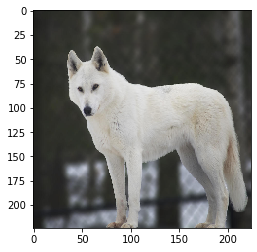

Attacked image; class 46 (Mexican_hairless)


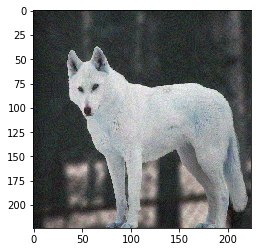

A sample image of class 46 (Mexican_hairless)


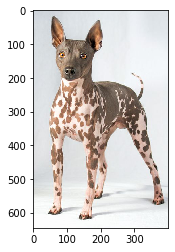

Output layer, neuron 46 has the highest value for the given attacked image


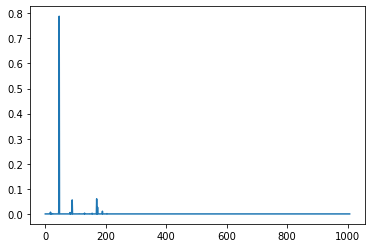

In [6]:
dirname = '../data/sample-images'
benign_image_path = '{}/{}'.format(dirname, 'white-wolf.jpg')
attacked_image_path = '{}/{}'.format(dirname, 'white-wolf-attacked-46.jpg')
attacked_class_image_path = '{}/{}'.format(dirname, 'american-hairless-sample.jpg')

print('Benign image; class 102 (White wolf)')
plt.figure()
raw_benign = plt.imread(benign_image_path)
raw_benign = cv2.resize(raw_benign, (args.img_width, args.img_height))
plt.imshow(raw_benign)
plt.show()

print('Attacked image; class 46 (Mexican_hairless)')
plt.figure()
raw_attacked = plt.imread(attacked_image_path)
raw_attacked = cv2.resize(raw_attacked, (args.img_width, args.img_height))
plt.imshow(raw_attacked)
plt.show()

print('A sample image of class 46 (Mexican_hairless)')
plt.figure()
attacked_class_sample = plt.imread(attacked_class_image_path)
plt.imshow(attacked_class_sample)
plt.show()

print('Output layer, neuron 46 has the highest value for the given attacked image')
y_eval, softmax_result = model_helper.get_predictions(googlenet, [raw_attacked])
plt.figure()
plt.plot(softmax_result[0])
plt.show()

## A_matrix: generate nodes

- A-matrix: shape of (#layers, #neurons)

### A_matrix of a **Benign** Image

In [7]:
As_benign = A_matrix.init_A_matrix_single_image(args)

In [8]:
act_scores_benign = model_helper.get_all_layers_activation_score(googlenet, [raw_benign], args.layers)

In [9]:
for layer in args.layers:
    As_benign[layer] = act_scores_benign[layer][0]

### A_matrix of a **Attacked** Image

In [10]:
As_attacked = A_matrix.init_A_matrix_single_image(args)

In [11]:
act_scores_attacked = model_helper.get_all_layers_activation_score(googlenet, [raw_attacked], args.layers)

In [12]:
for layer in args.layers:
    As_attacked[layer] = act_scores_attacked[layer][0]

## I_matrix: generate edges

- I_matrix for a given layer: (#neurons, #previous_neurons)

### I_matrix of a **Benign** Image

In [156]:
img = raw_benign

with tf.Graph().as_default():
    # Define activation render
    t_input = tf.placeholder(tf.float32, [None, 224, 224, 3])
    T = render.import_model(googlenet, t_input, None)

    # For each layer
    for i, layer in enumerate(args.layers):
        
        # Skip the first layer, since it doesn't have connection with previous neurons
        if layer == 'mixed3a':
            continue
            
        # Get weight tensors
        t_w0, t_w1, t_w2, t_w3, t_w4, t_w5 = model_helper.get_weight_tensors(layer)

        # Get intermediate layer's activation tensors
        prev_layer = args.layers[i - 1]
        t_a0, t_a1, t_a2 = model_helper.get_intermediate_layer_tensors(prev_layer, layer)
        
        # Define intermediate depthwise conv output tensors
        t_inf_0 = I_matrix.get_infs(t_a0, t_w0)
        t_inf_1 = I_matrix.get_infs(t_a1, t_w2)
        t_inf_2 = I_matrix.get_infs(t_a2, t_w4)
        t_inf_3 = I_matrix.get_infs(t_a0, t_w5)
        t_inf_4 = I_matrix.get_infs(t_a0, t_w1)
        t_inf_5 = I_matrix.get_infs(t_a0, t_w3)
        
        # Open the session
        with tf.Session() as sess:
            
            # Get the influence values
            inf_0, inf_1, inf_2, inf_3, inf_4, inf_5 = \
                sess.run(
                    [t_inf_0, t_inf_1, t_inf_2, t_inf_3, t_inf_4, t_inf_5],
                    feed_dict={t_input: [img]})
            
            print(layer)
            print(inf_0.shape)
            print(inf_1.shape)
            print(inf_2.shape)
            print(inf_3.shape)
            print(inf_4.shape)
            print(inf_5.shape)
            print()

mixed3b
(1, 32768)
(1, 24576)
(1, 3072)
(1, 16384)
(1, 32768)
(1, 8192)

mixed4a
(1, 92160)
(1, 19584)
(1, 768)
(1, 30720)
(1, 46080)
(1, 7680)

mixed4b
(1, 81280)
(1, 25088)
(1, 1536)
(1, 32512)
(1, 56896)
(1, 12192)

mixed4c
(1, 65536)
(1, 32768)
(1, 1536)
(1, 32768)
(1, 65536)
(1, 12288)

mixed4d
(1, 57344)
(1, 41472)
(1, 2048)
(1, 32768)
(1, 73728)
(1, 16384)

mixed4e
(1, 135168)
(1, 51200)
(1, 4096)
(1, 67584)
(1, 84480)
(1, 16896)

mixed5a
(1, 212992)
(1, 51200)
(1, 6144)
(1, 106496)
(1, 133120)
(1, 39936)

mixed5b
(1, 319488)
(1, 73728)
(1, 6144)
(1, 106496)
(1, 159744)
(1, 39936)



In [15]:
c = 0

num_in_channel = 256
num_out_channel = 480

influence_indices = [i * num_out_channel + c for i in range(num_in_channel)]
print(influence_indices)

[0, 480, 960, 1440, 1920, 2400, 2880, 3360, 3840, 4320, 4800, 5280, 5760, 6240, 6720, 7200, 7680, 8160, 8640, 9120, 9600, 10080, 10560, 11040, 11520, 12000, 12480, 12960, 13440, 13920, 14400, 14880, 15360, 15840, 16320, 16800, 17280, 17760, 18240, 18720, 19200, 19680, 20160, 20640, 21120, 21600, 22080, 22560, 23040, 23520, 24000, 24480, 24960, 25440, 25920, 26400, 26880, 27360, 27840, 28320, 28800, 29280, 29760, 30240, 30720, 31200, 31680, 32160, 32640, 33120, 33600, 34080, 34560, 35040, 35520, 36000, 36480, 36960, 37440, 37920, 38400, 38880, 39360, 39840, 40320, 40800, 41280, 41760, 42240, 42720, 43200, 43680, 44160, 44640, 45120, 45600, 46080, 46560, 47040, 47520, 48000, 48480, 48960, 49440, 49920, 50400, 50880, 51360, 51840, 52320, 52800, 53280, 53760, 54240, 54720, 55200, 55680, 56160, 56640, 57120, 57600, 58080, 58560, 59040, 59520, 60000, 60480, 60960, 61440, 61920, 62400, 62880, 63360, 63840, 64320, 64800, 65280, 65760, 66240, 66720, 67200, 67680, 68160, 68640, 69120, 69600, 700

In [149]:
lll = get_layers(googlenet.graph_def.node)

In [150]:
lll

['conv2d0',
 'conv2d1',
 'conv2d2',
 'mixed3a',
 'mixed3b',
 'mixed4a',
 'mixed4b',
 'mixed4c',
 'mixed4d',
 'mixed4e',
 'mixed5a',
 'mixed5b',
 'head0',
 'nn0',
 'softmax0',
 'head1',
 'nn1',
 'softmax1',
 'softmax2']